**Created by Muhammed El-Yamani**

**🚀 Clothing type classifier Techsquadeg**

**15 Jun 2022**


# Problem Statment

Assume that we would like to create **a clothing type classifier**. 

You are required to select one of the **freely available datasets** and **create an initial model** to deliver a prototype of the solution. 

It’s recommended to use google colab for this task since it’s free and easily shareable. 

**Deliverables:**


1. A Github repository containing your solution

2. A ReadMe detailing the steps you took to solve the problem, your approach, your data handling techniques, any problems you faced, and the results of your tests.

3. A summary of the results and metrics you choose to evaluate

4. A presentation to illustrate your results (will be discussed during the evaluation process)


-----------------------------------------------------
 



**Notes:**


1.   Use proper data handling and data loading: Done 

2.   Explore multiple solutions and showcase why you chose the final one
Be clear on your choice of metrics and why you chose them.

3. Make sure to write clean, modular, and well-documented code.: Done 

4. Make sure to keep your approach optimum as much as possible for deployment, with minimal model size and the number of FLOPS.


You are not expected to reach optimal results, but it is very critical for you to showcase how you approach the problem and outline your thought process.


Best of luck


In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/jobs_assignments/techsquadeg

## Import libraries

In [2]:
import urllib.request
import zipfile
import os
import progressbar
from math import ceil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms, models
import json
from tqdm import tqdm
import logging
from pathlib import Path
from torch.utils.data import Dataset
import re
import pandas as pd
import csv
import os
import pathlib
from tqdm import tqdm
from torchvision import datasets
import shutil
from collections import Counter
import matplotlib as mpl
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12) 
%matplotlib inline


mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

In [3]:
# helper files

from utils.scores import calc_accuracy
from utils import utils
from utils.load_dataset import get_dataset_dataloader

# from evaluate import evaluate
# from unet import UNet
# from net_utility import Net_Utility


## Global variables

In [4]:
LOCAL_DATASET_PATH='dataset'
LOCAL_RAW_DATASET_PATH = 'source_dataset'
CHECKPOINT_PATH='checkpoint'
GENERATE_IMAGES=False

In [5]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32
N_CLASSES = 46
SEED=0
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
MULTIPLE_TRAIN_SIZE = 2
LOADER_ARGS = dict(batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# EPOCHS = 5
EPOCHS = 1
LEARNING_RATE = 1e-3
TRAIN = True
print(f'Using device {DEVICE}')

Using device cuda


## Preparing Datasets

- source_dataset/Anno_coarse/
  - list_category_cloth.txt
  - list_category_img.txt

- source_dataset/Eval
  - list_eval_partition.txt

- source_dataset/Img
  - img.zip

In [6]:
def preperare_csv_files(source_dataset, dataset_path):
  if not os.path.isdir(f"{LOCAL_DATASET_PATH}"):
    os.mkdir(f"{LOCAL_DATASET_PATH}")

  data= dict()
  if not os.path.isfile(f'{dataset_path}/list_eval_partition.csv'):
    list_eval_partition_file = f'{source_dataset}/Eval/list_eval_partition.txt'
    list_eval_partition_df = pd.read_csv(list_eval_partition_file, skiprows=1,  delim_whitespace=True)
    list_eval_partition_df.to_csv(f'{dataset_path}/list_eval_partition.csv', sep=',', index=False)
  data['list_eval_partition'] = pd.read_csv(f'{LOCAL_DATASET_PATH}/list_eval_partition.csv')

  if not os.path.isfile(f'{dataset_path}/list_category_cloth.csv'):
    list_category_cloth_file = f'{source_dataset}/Anno_coarse/list_category_cloth.txt'
    list_category_cloth_df = pd.read_csv(list_category_cloth_file, skiprows=1,  delim_whitespace=True)
    list_category_cloth_df.to_csv(f'{dataset_path}/list_category_cloth.csv', sep=',', index=False)
  data['list_category_cloth'] = pd.read_csv(f'{LOCAL_DATASET_PATH}/list_category_cloth.csv')

  if not os.path.isfile(f'{dataset_path}/list_category_img.csv'):
    list_category_img_file = f'{source_dataset}/Anno_coarse/list_category_img.txt'
    list_category_img_df = pd.read_csv(list_category_img_file, skiprows=1,  delim_whitespace=True)
    list_category_img_df.to_csv(f'{dataset_path}/list_category_img.csv', sep=',', index=False)
  data['list_category_img'] = pd.read_csv(f'{LOCAL_DATASET_PATH}/list_category_img.csv')

  return data


In [7]:
def prepare_images(source_dataset_path, dataset_path, generate_images=True, extract=False):
  if generate_images:
    category = dict()

    data = preperare_csv_files(source_dataset_path, dataset_path)
    for split in ['train', 'val', 'test']:
      pathlib.Path(f'{dataset_path}/images_v2/{split}').mkdir(parents=True, exist_ok=True)
    df_split=data['list_eval_partition']
  
    path_imgs=f'{source_dataset_path}/Img/img.zip'
    if extract:
      with zipfile.ZipFile(path_imgs, 'r') as zf:
           for member in tqdm(zf.infolist(), desc='Extracting '):
               try:
                   zf.extract(member, f"{dataset_path}/imgs_v2")
               except zipfile.error as e:
                   pass
    for i in tqdm(range(df_split.shape[0]), desc="Copying images "):
      local_image_path=df_split.iloc[i]['image_name']
      split=df_split.iloc[i]['evaluation_status']
      image_path=f'{f"{dataset_path}/imgs_v2"}/{local_image_path}'

      folder_name, image_name = image_path.split('/')[3:]
      category_name = folder_name.split('_')[-1]
      if category_name in category:
        if split in category[category_name]:
           category[category_name][split] +=1
        else:
          category[category_name][split] = 1
      else:
          category[category_name]=dict()
          category[category_name][split] = 1
      n = category[category_name][split]
      image_name_updated = f'img_{str(n).zfill(8)}.jpg'
      pathlib.Path(f'{dataset_path}/images_v2/{split}/{category_name}').mkdir(parents=True, exist_ok=True)


      new_image_path = f"{dataset_path}/images_v2/{split}/{category_name}/{image_name_updated}"

      shutil.copyfile(image_path, new_image_path)

In [8]:
prepare_images(LOCAL_RAW_DATASET_PATH, LOCAL_DATASET_PATH, GENERATE_IMAGES)

Notes README.md from source_dataset:
1. The long side of images are resized to 300;
2. The aspect ratios of original images are kept unchanged.

## Data loaders 

- transforms
- augmentation

In [9]:
dataloaders= dict()
image_datasets= dict()
data_transforms= dict()
train_dataset, train_dataloader=get_dataset_dataloader(dataset_path= LOCAL_DATASET_PATH, image_size= IMAGE_SIZE, split='train', aug_train=True, keep_data_factor= 0.1, seed = SEED, shuffle=True, loader_args=LOADER_ARGS)
val_dataset, val_dataloader=get_dataset_dataloader(dataset_path= LOCAL_DATASET_PATH, image_size= IMAGE_SIZE, split='val', aug_train=True, keep_data_factor= 0.1, seed = SEED, shuffle=True, loader_args=LOADER_ARGS)
test_dataset, test_dataloader=get_dataset_dataloader(dataset_path= LOCAL_DATASET_PATH, image_size= IMAGE_SIZE, split='test', aug_train=True, keep_data_factor= 0.1, seed = SEED, shuffle=True, loader_args=LOADER_ARGS)

train dataset: 20922 images
val dataset: 4000 images
test dataset: 4000 images


In [10]:
image_datasets={'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
dataloaders={'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

In [11]:
classes_names = image_datasets['train'].class_names
print("number of classes in train datasets: ", len(classes_names))

number of classes in train datasets:  46


In [12]:
print("number of classes in val datasets: ", len(image_datasets['val'].class_names))

number of classes in val datasets:  46


In [13]:
print("number of classes in tes datasets: ", len(image_datasets['test'].class_names))

number of classes in tes datasets:  46


## Explore The Dataset

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Explore The Datase:</u></b><br>
 
* <i>RGB images</i><br>
* <i>train dataset: 209222 images</i><br>
* <i>val dataset: 40000 images</i><br>
* <i>test dataset: 40000 images </i><br>
* <i>Classes: 46 </i><br>
* <i>The classes not balanced with skewed graph </i><br>
* <i>The class **Dress** has the greatest size with **52138**  </i><br>
* <i>The class **Halter** has the lowest size with **11**  </i><br>
* <i>The image has more than label but annotated with only label. So there is noise in the images. </i><br>

----------------------------------------------------------------

**Solution for imbalanced**

We can solve this problem by making augmentation to generate more datasets for the classes with the weights of their distribution.


We have 52138 images for Dress. So the new data will be 52138*46 ~ 2.4e6. 

**The advantages:**

- The model will not be biased towards some classes and perhaps we get better results.

From 2.1e4   to   2.4e6.

I will let this approach for future works.

----------------------------------------------------------------

**The original dataset takes great time to train**

The original data has a large dataset and takes a very long time to evaluate, almost 2 hours per validation set. 

So I decided to work only on 10% of the original data to speed up my work.

And this approach has another advantage which tries to solve the imbalanced data, as we see in the distributions below. 

----------------------------------------------------------------

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>After preprocessing & Augmentation & taking the most important data:</u></b><br>
 
* <i>Normalaized RGB images</i><br>
* <i>train dataset: 20922 images</i><br>
* <i>val dataset: 4000 images</i><br>
* <i>test dataset: 4000 images </i><br>
* <i>Classes: 46 </i><br>
* <i>The classes almost balanced better than original </i><br>
* <i>The class **Dress** has the greatest size with **723**  </i><br>
* <i>The class **Halter** has the lowest size with **11**  </i><br>

In [14]:
# image_datasets['train'].plot_distribution()

In [15]:
# image_datasets['val'].plot_distribution()

In [16]:
# image_datasets['test'].plot_distribution()

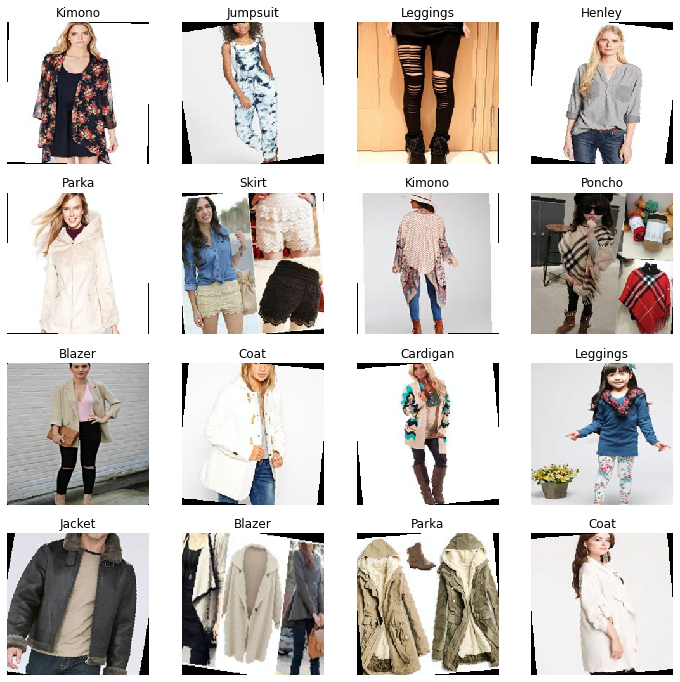

In [17]:
train_data_iter = iter(dataloaders['train'])
batch = train_data_iter.next()
images, labels = batch
plt.figure(figsize=(12, 12))
for index in range(0, min(16, len(images))):
    ax = plt.subplot(4, 4, index + 1)
    utils.imshow(images[index], ax=ax, title =classes_names[labels[index]] , normalize=True)



## Training

### <span style="color:#e76f51;">References</span>

- <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_DeepFashion_Powering_Robust_CVPR_2016_paper.pdf">DeepFashion: Powering Robust Clothes Recognition and Retrieval with Rich Annotations, CVPR 2016</a>


- Transfere learning on vgg16...
- Build smaller custom cnn

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>EXperiment1: Transfer learning using vgg16:</u></b><br>


* <i>Because it is used in the paper of the reference above</i><br>
 
* <i>The descriptor has size <b>25088 1-dim vector</b> from any size from the image</i><br>


In [18]:
# Choose the pretrained model
model = models.vgg16(pretrained=True)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [19]:
# Freeze the parameters
for param in model.parameters():
    param.requires_grad = False

In [20]:
# Build the network
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, dropout_p = 0.2):
        super().__init__()
        # Build the network
        self.layers = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        self.layers.extend([nn.Linear(n1, n2) for n1, n2 in zip(hidden_sizes, hidden_sizes[1:])])
        self.layers.extend([nn.Linear(hidden_sizes[-1], output_size)])
        # Build dropout
        self.drop_out = nn.Dropout(dropout_p)
    def forward(self, x):
        # iterate each layer
        for i, each in enumerate(self.layers):
            if i != len(self.layers) - 1:
                # get output of layer i
                x = each(x)
                # get acctivation relu
                x = F.relu(x)
                # make drop_out with p
                x = self.drop_out(x)
            else:
                # last layer = output layer
                x = each(x)
                x = F.log_softmax(x, dim=1)
        return x

In [21]:
# define netwrok
classifier = Network(input_size=25088, output_size=N_CLASSES, hidden_sizes=[64])
# transfer learning
model.classifier = classifier
# Configure optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
# criterion
criterion = nn.NLLLoss()

In [22]:
# Get preds
def get_predictions(log_ps):
    with torch.no_grad():
        # get exp of log to get probabilities
        ps = torch.exp(log_ps)
        # get top_p and top_class
        top_p, top_class = ps.topk(1, dim=1)
        return top_class

In [23]:
len(val_dataloader)

125

In [24]:
# Make validation/test inference function
def validation_test(model, validation_test_loader, desc='Validation'):
    """make validation or test inference based on the data"""

    model.eval()

    with torch.no_grad():
        # find what is the existed device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)
        # intial helping variables
        num_val_batches = len(validation_test_loader)
        accum_accuracy = 0
        running_loss = 0
        # iterate over the data
        for batch in tqdm(validation_test_loader, total=num_val_batches, desc=f'{desc} round', unit='batch', leave=False):
            images, labels = batch
            labels, images = labels.to(device), images.to(device)
            # forward pass
            log_ps = model(images)
            # get predictions
            preds = get_predictions(log_ps)
            # get loss
            loss = criterion(log_ps, labels)
            
            running_loss += loss.item()
            accum_accuracy += calc_accuracy(labels, preds)
            
        # get running_loss, accuracy metrics
        return running_loss / len(validation_test_loader), accum_accuracy / len(validation_test_loader)

In [25]:
class EarlyStopping:
    """Save the best model during the trainning and finish trainning 
    if there is decrease for valid accuracy in delay epochs"""
    def __init__(self, delay, checkpoint_save="save.pth"):
        # path save chekpoint for the best model during training
        self.checkpoint_save = checkpoint_save
        # delay in number of epochs
        self.delay = delay
        # count continuous decrease in accuracy
        self.count_down = 0
        # record prev valid accuracy
        self.prev_valid_accuracy = None
        # record the best accuracy to save the best model
        self.best_accuracy = None
    def track(self, valid_accuracy, model, train_loss, valid_loss):
        self.model = model
        self.train_loss = train_loss 
        self.valid_loss = valid_loss
        self.valid_accuracy = valid_accuracy
        
        if self.prev_valid_accuracy != None and valid_accuracy <= self.prev_valid_accuracy:
            print("Warning: there is deacrease in valid accuracy")
            self.count_down += 1
        else:
            self.count_down = 0
        if self.best_accuracy == None or valid_accuracy > self.best_accuracy:
            print("Winning: better model")
            # save the best model
            torch.save(model.state_dict(), self.checkpoint_save)
            # update the best accuracy metric
            self.best_accuracy = valid_accuracy
        # update prev_valid_accuracy
        self.prev_valid_accuracy = valid_accuracy
        if self.count_down == self.delay:
            # Finish training, there is continuous decreasing in accuracy
            return True
        else:
            return False
    def get_the_best_model(self):
        state_dict = torch.load(self.checkpoint_save)
        self.model.load_state_dict(state_dict)
        return self.model
    def measurements(self):
        return self.train_loss, self.valid_loss, self.valid_accuracy

In [26]:
early_stopping = EarlyStopping(2)

In [27]:
n_train=len(image_datasets['train'])

In [28]:
# define Train function
def train(model, optimizer, criterion, trainloader, validloader, epochs=5, print_every=None):
    # find what is the existed device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    if print_every is None:
        # every 10 % epoch
        print_every = int(0.1 * len(train_dataloader))
    # intial helping variables
    train_loss_container = []
    valid_loss_container = []
    global_steps = 0
    # loop over epochs
    for e in range(epochs):
        with tqdm(total=n_train, desc=f'Epoch {e}/{EPOCHS}', unit='img') as pbar:
            # intial helping variables
            running_loss = 0
            # loop over batchs of trainloader
            for images, labels in trainloader:
                model.train()
                global_steps += 1
                labels, images = labels.to(device), images.to(device)

                # clear gradient
                optimizer.zero_grad()
                # forward pass
                log_ps = model(images)
                # get loss
                loss = criterion(log_ps, labels)
                # backward pass
                loss.backward()
                # update weights by making step for optimizer
                optimizer.step()

                running_loss += loss.item()
                pbar.update(images.shape[0])
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # valid condition every print_every
                if global_steps % print_every == 0:
                    train_loss = running_loss / print_every
                    valid_loss, valid_accuracy = validation_test(
                        model, validloader)
                    train_loss_container.append(train_loss)
                    valid_loss_container.append(valid_loss)
                    running_loss = 0
                    # print_results
                    print(
                        f"{e+1}/{epochs} .. train_loss: {(train_loss) :0.3f}.. valid_loss: {(valid_loss) :0.3f} .. valid_accuracy: {(valid_accuracy * 100) :0.3f}%")

            if early_stopping.track(valid_accuracy, model, train_loss, valid_loss):
                print("Early stopping")
                print("Having the best model")
                model = early_stopping.get_the_best_model()
                train_loss, valid_loss, valid_accuracy = early_stopping.measurements()
                print(
                    f".. train_loss: {(train_loss) :0.3f}.. valid_loss: {(valid_loss) :0.3f} .. valid_accuracy: {(valid_accuracy * 100) :0.3f}%")
                break

    # plot train_loss and valid_loss
    plt.plot(train_loss_container,  label="Train loss")
    plt.plot(valid_loss_container,  label="Valid loss")
    plt.legend()
    plt.show()

    print("Having the best model")
    model = early_stopping.get_the_best_model()
    train_loss, valid_loss, valid_accuracy = early_stopping.measurements()
    print(
        f".. train_loss: {(train_loss) :0.3f}.. valid_loss: {(valid_loss) :0.3f} .. valid_accuracy: {(valid_accuracy * 100) :0.3f}%")

    return train_loss, valid_loss, valid_accuracy


In [29]:
train_loss, valid_loss, valid_accuracy = train(model, optimizer, criterion, dataloaders['train'], dataloaders['val'], epochs = EPOCHS)

Epoch 0/1:   0%|          | 32/20922 [00:19<28:00, 12.43img/s, loss (batch)=3.91]

100


1/1 .. train_loss: 3.914.. valid_loss: 4.113 .. valid_accuracy: 111.775%


Epoch 0/1:   0%|          | 64/20922 [01:27<7:53:19,  1.36s/img, loss (batch)=4.52]


KeyboardInterrupt: 

## Testing

## Evaluation

## Visualiaztion